In [1]:
import numpy as np 
import numpy.ma as ma

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

In [2]:
CA_clean = Table(fits.open('CA_clean.fits')[1].data)
star = CA_clean[51]
print('APOGEE_ID', star['APOGEE_ID'])

aspcap_url = 'https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TSCOPE}/{FIELD}/aspcapStar-dr17-{ID}.fits'.format(
                TSCOPE = star['TELESCOPE'], FIELD = star['FIELD'], ID = star['APOGEE_ID'])

print('Download to your working directory:')
print(aspcap_url)

APOGEE_ID 2M04101642+3535373
Download to your working directory:
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/apo25m/CA_162-11_btx/aspcapStar-dr17-2M04101642+3535373.fits


In [3]:
aspcap = fits.open('aspcapStar-dr17-2M04101642+3535373.fits')

# Model Residuals - access
You can download median residuals [here](none). The filestructure for each is 

|  Header  | Contents |
| -- | -- | 
| 0 | PrimaryHDU |
| 1 | Median binned residual |
| 2 | Mean binned residual |
| 3 | Standard deviation |
| 4 | Median absolute deviation |
| 5 | 16th percentile |
| 6 | 84th percentile |
| 7 | N stars / pixel |

and a table of metadata for each parameter bin is described in `meta.fits`.

For a set of `TEFF`, `LOGG`, and `M_H` parameters, the path to the appropriate binned median residual file can be selected using the following `get_medres()` function: 

In [4]:
medres_dir = 'Residuals/'
meta_new = Table(fits.open(medres_dir + 'meta.fits')[1].data)

def get_medres(teff, logg, m_h, medres_dir = 'Residuals/'):
    rowselect = np.where(np.logical_and.reduce(
                    [teff >= meta_new['TEFF_MIN'], teff < meta_new['TEFF_MAX'], 
                    logg >= meta_new['LOGG_MIN'], logg < meta_new['LOGG_MAX'],
                   m_h >= meta_new['M_H_MIN'], m_h < meta_new['M_H_MAX']]))[0]
    
    row = meta_new[rowselect]
    filename = row['FNAME'].item()
    return medres_dir + filename

medres = fits.open(get_medres(star['TEFF'], star['LOGG'], star['M_H']), medres_dir = medres_dir)
# if you don't want to download the whole folder, the model residual corresponding to the chosen example 
# star is available at 

In [5]:
residual = aspcap[1].data / aspcap[3].data
median_residual = medres[1].data
corrected_residual = residual / median_residual

/var/folders/pz/sgyllgv13qnfqwl9zwk1zd380000gn/T/ipykernel_42946/1260263165.py:1: RuntimeWarning: invalid value encountered in true_divide
  residual = aspcap[1].data / aspcap[3].data


## Applying median residual corrections to stellar residuals

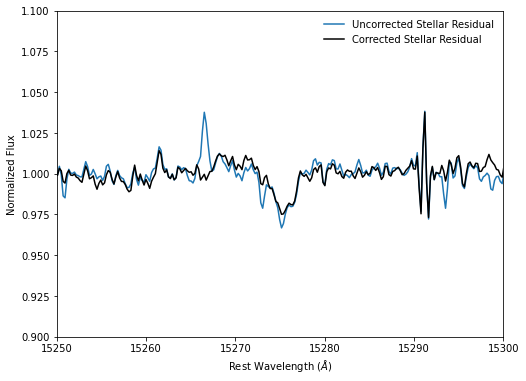

In [6]:
# Calculate ASPCAP residual with and without correction from our median residual
dib_position = 15272.42
wavs = np.power(10, 4.179 + 6e-06 * np.arange(8575)) 


fig, ax = plt.subplots(figsize = (8,6))

ax.plot(wavs, residual, label = 'Uncorrected Stellar Residual', c = 'C0')
ax.plot(wavs, corrected_residual, label = 'Corrected Stellar Residual', c = 'k')

ax.set_xlim(15250, 15300)
# ax.plot([dib_position, dib_position], [0.9, 1.1], 
#             label = '15272.42 $\AA$', color = 'orange', linestyle = 'dashed')
ax.set_ylim(0.9, 1.1)
ax.set_xlabel('Rest Wavelength ($\AA$)')
ax.set_ylabel('Normalized Flux')
ax.legend(frameon = False)

plt.show()

## Check out the corresponding median residual

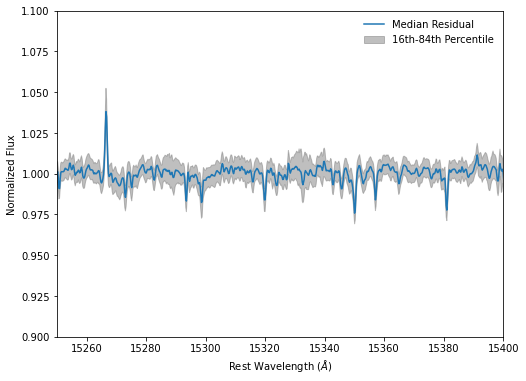

In [7]:
perc16 = medres[5].data
perc84 = medres[6].data

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(wavs, medres[1].data, label = 'Median Residual')
ax.fill_between(wavs, perc84, perc16, color = 'grey', 
                alpha = 0.5, label = '16th-84th Percentile')
ax.set_xlim(15250, 15400)
ax.set_ylim(0.9, 1.1)
ax.set_xlabel('Rest Wavelength ($\AA$)')
ax.set_ylabel('Normalized Flux')
ax.legend(frameon = False)
plt.show()

In [8]:
medres[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                 8575                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
NAME    = 'MEDIAN  '                                                            
NBIN    =                 1939                                                  
TEFF_MIN=                 4700                                                  
TEFF_MAX=                 4750                                                  
LOGG_MIN=                  2.4                                                  
LOGG_MAX=                  2.6                                                  
M_H_MIN =                 -0